## Detecting hate speech using a pipeline built on XGB Classifier/SGD Classifier/Naive Bayes and comparing accuracy of each. 

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#### Here df1 is training dataset and df2 is test dataset for ease of typing.

In [2]:
# Load data

df1 = pd.read_csv(r'C:\Users\91988\Downloads\hate speech\train.csv')
df2 = pd.read_csv(r'C:\Users\91988\Downloads\hate speech\test.csv')

### Data Preprocessing

In [3]:
# Visualize and clean

print(df1.shape)
print(df2.shape)

(31962, 3)
(17197, 2)


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [6]:
df1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
df2.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [8]:
df1.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
df2.isnull().sum()

id       0
tweet    0
dtype: int64

In [10]:
print(df1['label'].unique())

[0 1]


#### 0 = Viewer Friendly 1 = Hateful

<Axes: xlabel='label', ylabel='count'>

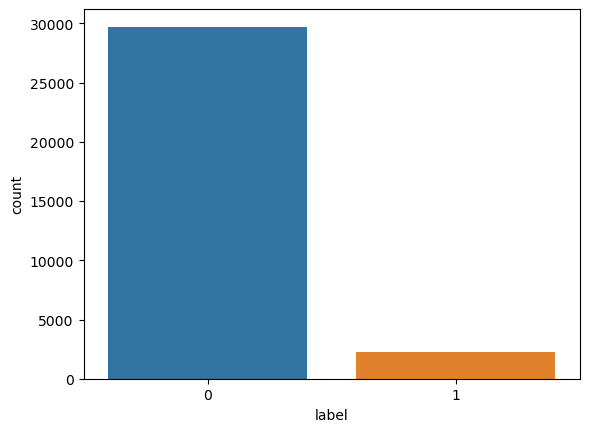

In [11]:
# Count plot

df1['label'] = df1['label'].astype('category')
sns.countplot(data = df1, x = 'label')

In [12]:
# Data Cleaning

def clean_txt(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df
df1_clean = clean_txt(df1, 'tweet')
df2_clean = clean_txt(df2, 'tweet')

In [13]:
# Corellation plot

df1['label'] = df1['label'].astype('int64')
correlation = df1['id'].corr(df1['label'])
print(f'Corellation between id and label is : {correlation}')

Corellation between id and label is : 0.002780217051410005


#### So we can say that it's not just a few id's spreading hate, but is quite homogenous across the user-base. Hateful tweets overall is a small percentage of all tweets which leads to an imbalance in training data. Can be fixed by oversampling.

In [14]:
# Oversampling

df1_majority = df1_clean[df1_clean.label == 0]
df1_minority = df1_clean[df1_clean.label == 1]
df1_minority_new = resample(df1_minority, replace = True, n_samples = len(df1_majority), random_state = 50)
df1_new = pd.concat([df1_majority, df1_minority_new])
df1_new['label'].value_counts()

label
0    29720
1    29720
Name: count, dtype: int64

### Creating a pipeline

#### Separate pipelines for each classifier.

In [15]:
# XGBoost pipeline

pipe_xgb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('xgb', XGBClassifier()),])

In [16]:
# SGD pipeline

pipe_sgd = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('sgd', SGDClassifier()),])

In [17]:
# Naive Bayes pipeline

pipe_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('nb', MultinomialNB()),])

In [18]:
# Split train dataset into train and test

x_train, x_test, y_train, y_test = train_test_split(df1_new['tweet'], df1_new['label'], random_state = 0)

#### Fit models built on each pipeline

In [19]:
# XGB Classifier

model_xgb = pipe_xgb.fit(x_train, y_train)
y_pred_1 = model_xgb.predict(x_test)
f1_score(y_test, y_pred_1)

0.908859913072551

In [20]:
# SGD Classifier

model_sgd = pipe_sgd.fit(x_train, y_train)
y_pred_2 = model_sgd.predict(x_test)
f1_score(y_test, y_pred_2)

0.966690756192103

In [21]:
# Naive Bayes

model_nb = pipe_nb.fit(x_train, y_train)
y_pred_3 = model_nb.predict(x_test)
f1_score(y_test, y_pred_3)

0.9523318732285493

#### As we can see SGD Classifier performs the best with Naive Bayes Classifier being a close second. XBG Classifier had way lesser accuracy possibly due to the lack of hyperparameter tuning.

### Using the SGD Classifier on the test dataset df2

In [22]:
predictions = model_sgd.predict(df2['tweet'])
print(predictions)

[0 1 0 ... 0 0 0]


In [23]:
# Write the predictions to a csv file

df2['predictions'] = predictions
df2.to_csv('predictions.csv', index = True)